## ECON 210C: Discussion Week 6
## Dynamic Programming in Python: Solving the RBC Steady-State
Written by: John Juneau (jjuneau@ucsd.edu)

In [4]:
# Packages needed for this Assignment
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

## Introduction: Solve A Familiar Problem in Python

We've solved a standard neoclassical growth model in Matlab. In particular, we've performed value function iteration for:

$$
V(K) = \max_{C} \left\{ U(C) + \beta V((1-\delta)K + AK^{\alpha} -C) \right\}  
$$

Let's start off by seeing how to do that in Python. 

In particular, I'm going to define a class (essentially, a function) that has a variety of inputs (e.g., parameter values) and then solves the model defined within the class using value function iteration. 

In [11]:
##########    1. Define an object to solve the model under different parameterizations  ##############
######################################################################################################
######################################################################################################
class solve_Neoclassical_Model:
    def __init__(self, 
                 beta=0.99, r=0,
                 alpha=0.4, delta=0.025,
                 tfpq=1,
                 xmin=1e-5, xmax=100, xgrid_size=100, 
                 cgrid = 100,
                 v0_min=1e-5, v0_max=1,
                 fv_lower=-10000, fv_upper = 0,
                 max_iter=2000, tolerance=1e-5
                 ):
        # Model Parameters (Imported)
        self.beta       = beta
        self.r          = r
        self.alpha      = alpha
        self.delta      = delta
        self.tfpq       = tfpq
        self.xmin       = xmin
        self.xmax       = xmax
        self.xgrid_size  = xgrid_size
        self.cgrid      = cgrid
        self.v0_min     = v0_min
        self.v0_max     = v0_max
        # Interpolation Parameters (imported)
        self.fv_lower   = fv_lower
        self.fv_upper   = fv_upper
        # VFI Parameters (Imported)
        self.max_iter   = max_iter
        self.tolerance  = tolerance
        # Setup Model
        self.x          = np.linspace(xmin, xmax, xgrid_size)  # State variable vector
        self.v0         = np.linspace(v0_min, v0_max, xgrid_size)  # Initial value function guess
        self.c_cand     = np.linspace(xmin, xmax, cgrid)  # Choice variable vector
        self.xprime     = (1-self.delta)*self.x[np.newaxis, :] + self.tfpq*self.x[np.newaxis, :]**self.alpha - self.c_cand[:, np.newaxis]
        # define utility function --- makes it easy to change later
        def utility(self, c):
            return np.log(c)
        # Interpolation function
        def interpol_v(self, v):
            f_interp        = interp1d(self.x, v, kind='linear', bounds_error=False, fill_value=(self.fv_lower, self.fv_upper))
            v_prime_cand    = f_interp(self.xprime)
            return v_prime_cand
        # Value Function Iteration
        iteration = 0
        # loop until the value function converges and plot policy function and value function
        v_new = self.v0
        while(iteration < self.max_iter):
            v = v_new
            v_prime = interpol_v(self, v)
            # f_interp    = interp1d(self.x, v, kind='linear', bounds_error=False, fill_value=(-100000, 0))
            # v_prime     = f_interp(self.xprime)
            v_implied = utility(self, self.c_cand[:, np.newaxis]) + self.beta * v_prime
            # find the consumption choice that maximizes implied v
            c_index = np.argmax(v_implied, axis=0) 
            c = self.c_cand[c_index]
            v_new = np.max(v_implied, axis=0)
            error = abs(v_new - v)
            max_error = np.max(error)
            # mean_error = np.mean(error)
            if max_error < self.tolerance:
                print("Converged after " + str(iteration) + " iterations.")
                break
            else:    
                iteration = iteration + 1    
        if iteration >= self.max_iter:
            print("Convergence failed after " + str(iteration) + " attempts.")
        self.c = c
        self.v = v_new
        self.iteration = iteration 
    

In [12]:
# Using the class defined above, let's solve the model. 
neo_model = solve_Neoclassical_Model(cgrid=5000) 

Converged after 1161 iterations.


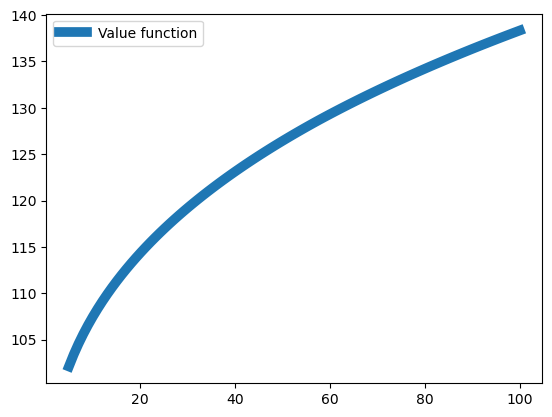

In [13]:
# Plot the value function we solved for
plt.plot(neo_model.x[5:], neo_model.v[5:], label='Value function', linewidth=7.0)
plt.legend()
plt.show()


Let's consider some alternative parameterizations to see if this is working as we expect. 

In [17]:
### Changing beta to 0.9
neo_model2 = solve_Neoclassical_Model(beta=0.9,cgrid=5000)
### Change TFPQ to 3
neo_model3 = solve_Neoclassical_Model(tfpq =3,cgrid=5000)


Converged after 121 iterations.
Converged after 1247 iterations.


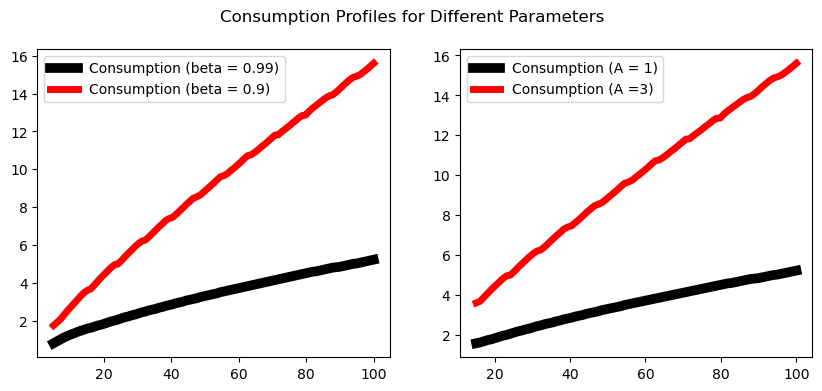

In [18]:
### Plot consumption for the different parameterizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Consumption Profiles for Different Parameters')
ax1.plot(neo_model.x[5:], neo_model.c[5:], label='Consumption (beta = 0.99)', linewidth=7.0, color = 'black')
ax1.plot(neo_model2.x[5:], neo_model2.c[5:], label='Consumption (beta = 0.9)', linewidth=5.0, color = 'red')
ax1.legend()
ax2.plot(neo_model.x[15:], neo_model.c[15:], label='Consumption (A = 1)', linewidth=7.0, color = 'black')
ax2.plot(neo_model2.x[15:], neo_model2.c[15:], label='Consumption (A =3)', linewidth=5.0, color = 'red')
ax2.legend()


## Solving the RBC Model's Steady-State

We're going to modify the code above to instead solve the RBC model's steady-state. Note: We're only solving the steady-state here. 

Some Important Questions: 
1. What change(s) do we need to make now that HH chooses $l$ optimally?
    - We could loop through candidate values of $l$ and execute VFI for $c$ each time.
    - Better: Exploit optimality conditions:
    $$
        - u_l = u_c w \qquad \text{where} \qquad w = (1-\alpha) \frac{y}{l} \qquad \implies l = (\frac{c^{-\gamma}}{\psi})^{\frac{1}{\psi}}
    $$

2. What change(s) do we need to make for the presence of the firm problem?
    - We could solve for prices each time and incorporate this into the HH problem.
    - Better: Euler's Theorem tells us $wl + rk = y$ for $w = mpl$ and $r = mpk$.

3. What do we need to impose on $z$ to ensure steady-state?
    - Let's impose $z = 1$ to achieve steady-state. 



